# This file contains proccess of building model for recognizing dogs breed. 
We created our model using this pre-trained neural network - it identifies simple shapes and more complex visual patterns. We used pretrained model InceptionV3. We cutted the prediction layer of pre-trained CNN, and then attached our layers at the end. These built "classifier" that makes sense of the patterns previous layers provide. Just before an output layer, we added the Softmax layer, which assigns decimal probabilities to each class(breed).

Model was trained on data from keras https://www.kaggle.com/c/dog-breed-identification/data. I downloaded the data and unpacked it on my google Drive to path  "/content/drive/MyDrive/Dogs-ML/Dogs_unzipped/".

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import SGD, Adam
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3  import preprocess_input as inception_v3_preprocessor

In [6]:
path = "/content/drive/MyDrive/Dogs-ML/Dogs_unzipped/"
train_path = os.path.join(path, "train/*")
test_path = os.path.join(path, "test/*")
labels_path = os.path.join(path, "labels.csv")

labels_df = pd.read_csv(labels_path)
breed = labels_df["breed"].unique()

breed2id = {name: i for i, name in enumerate(breed)}

In [7]:
ids = glob(train_path) #all train images
labels = []
for image_id in ids:
  image_id = image_id.split("/")[-1].split(".")[0]
  breed_name = list(labels_df[labels_df.id==image_id]["breed"])[0]
  breed_idx = breed2id[breed_name]
  labels.append(breed_idx)

In [8]:
#Splitting the dataset
train_x, valid_x = train_test_split(ids, test_size=0.2, random_state=42)
train_y, valid_y = train_test_split(labels, test_size=0.2, random_state=42)

#Parameters
SIZE = 224
NUM_CLASSES = 120
LEARNING_RATE = 1e-4
BATCH = 16
EPOCHS = 10

In [9]:
def read_image(path, size):
  image=cv2.imread(path,cv2.IMREAD_COLOR)
  image = cv2.resize(image, (size, size))
  image = image/255.0
  image = image.astype(np.float32)
  return image

def parse_data(x,y):
  x = x.decode()

  num_class =120
  size = 224

  image = read_image(x,size)
  label= [0]*num_class
  label[y] = 1
  label = np.array(label)
  label = label.astype(np.int32)

  return image, label

def tf_parse(x,y):
  x,y = tf.numpy_function(parse_data, [x,y], [tf.float32, tf.int32])
  x.set_shape((224,224,3))
  y.set_shape((120))
  return x,y


def tf_dataset(x,y,batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

In [10]:
def build_modelInceptionV3(size, num_classes=120, trainable=False):
    inputs = Input(shape=(size, size, 3))
    backbone = InceptionV3(
        input_tensor=inputs, 
        include_top=False, 
        weights="imagenet")
    backbone.trainable = trainable
    x = backbone.output

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    return model

In [ ]:
  model1 = build_modelInceptionV3(SIZE, NUM_CLASSES)
  model1.compile(optimizer='sgd', 
	loss='categorical_crossentropy', 
	metrics=['accuracy'])

In [12]:
checkpoint = ModelCheckpoint("modelV3.h5", monitor='val_accuracy',
	verbose=1, save_best_only=True, 
	mode='auto', save_weights_only=False)

callbacks_list = [ checkpoint ]

In [ ]:
train_dataset = tf_dataset(train_x, train_y, BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, BATCH)
train_steps = (len(train_x)//BATCH)+1
valid_steps = (len(valid_x)//BATCH)+1
history = model1.fit(train_dataset, 
          steps_per_epoch = train_steps,
          validation_steps = valid_steps,
          validation_data=valid_dataset, epochs=EPOCHS, callbacks=callbacks_list)

After fitting model I plotted how loss and accuracy changed throughout epochs, you can see the results below.

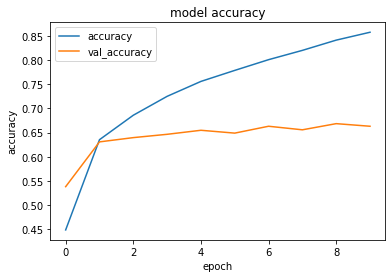

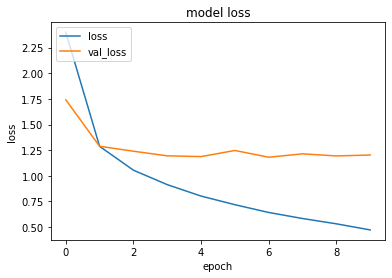

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
    
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()